In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import time
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from datetime import date
import numpy as np
from pycaret.classification import *
from scripts.TeoriaRetornos import *
from scripts.SeasonUpdater import *
import re

### Atualização de temporada

In [2]:
def clean_name(name):
    name = re.sub(r'\s*-.*$', '', name.strip())  # Remover informações extras
    return name  # Caso contrário, padronizar nome com letras maiúsculas iniciais

In [3]:
# atualiza_temporada('https://www.flashscore.com.br/beisebol/mexico/lmb/resultados/', 'data/lmb/lmb-2023.csv', 13)
# atualiza_temporada('https://www.flashscore.com.br/beisebol/eua/mlb/resultados/', 'data/mlb/mlb-2023.csv', 20)

## Scraping dos jogos do dia

In [4]:
hoje = date.today()
lista_ligas = ['MLB']

dia = "hoje"

In [5]:
# Instanciando o Objeto ChromeOptions
options = webdriver.EdgeOptions()

# Passando algumas opções para esse ChromeOptions
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Criação do WebDriver do Chrome
wd_Chrome = webdriver.Edge(options=options)

# Com o WebDrive a gente consegue a pedir a página (URL)
wd_Chrome.get("https://www.flashscore.com.br/beisebol/")
time.sleep(2)

# Para jogos do dia seguinte
if dia == "amanha":
    wd_Chrome.find_element(By.XPATH,'//*[@id="live-table"]/div[1]/div[2]/div/button[3]').send_keys(Keys.ENTER)
    time.sleep(2)

# Pegando o ID dos Jogos
id_jogos = []
jogos = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.event__match--scheduled')

for i in jogos:
    id_jogos.append(i.get_attribute("id"))

# Exemplo de ID de um jogo: 'g_1_Gb7buXVt'    
id_jogos = [i[4:] for i in id_jogos]

base_jogos = pd.DataFrame({})

for link in tqdm(id_jogos, total=len(id_jogos)):
    wd_Chrome.get(f'https://www.flashscore.com.br/jogo/{link}/#/resumo-de-jogo')
    
    Odds_H = 0
    Odds_A = 0
    Over_Line = 0
    Odds_Over = 0
    Odds_Under = 0
    HA_Line = 0
    HA_Odds_H = 0
    HA_Odds_A = 0

    # Pegando as Informacoes Básicas do Jogo
    try:
        Date = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__startTime').text.split(' ')[0]
        Season = Date.split('.')[2]
        League = wd_Chrome.find_element(By.CSS_SELECTOR,'span.tournamentHeader__country')
        League = League.find_element(By.CSS_SELECTOR,'a').text
        League = clean_name(League)
        if League not in lista_ligas:
            # Condição satisfeita, pula para a próxima iteração do loop
            continue
        Time = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__startTime').text.split(' ')[1]
        Home = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__home')
        Home = Home.find_element(By.CSS_SELECTOR,'div.participant__participantName').text
        Away = wd_Chrome.find_element(By.CSS_SELECTOR,'div.duelParticipant__away')
        Away = Away.find_element(By.CSS_SELECTOR,'div.participant__participantName').text


        # Match Odds
        wd_Chrome.get(f'https://www.flashscore.com.br/jogo/{link}/#/comparacao-de-odds/home-away/tr-incluindo-prol')
        time.sleep(1)
        celulas = wd_Chrome.find_elements(By.CSS_SELECTOR,'div.ui-table__row')
        
        for celula in celulas:
            bookie = celula.find_element(By.CSS_SELECTOR,'img.prematchLogo')
            bookie = bookie.get_attribute('title')
            if (((bookie == 'bet365') and (Odds_H == 0)) or ((bookie == '1xBet') and (Odds_H == 0))):
                Odds_H = float(celula.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[0].text)
                Odds_A = float(celula.find_elements(By.CSS_SELECTOR,'a.oddsCell__odd')[1].text)
            else:
                pass


        # Over/Under
        wd_Chrome.get(f'https://www.flashscore.com.br/jogo/{link}/#/comparacao-de-odds/acima-abaixo/tr-incluindo-prol')
        time.sleep(1)
        celulas = wd_Chrome.find_elements(By.CLASS_NAME,'ui-table__row')


        for celula in celulas:
            bookie = celula.find_element(By.CSS_SELECTOR, 'img.prematchLogo').get_attribute('title')
            Odds_Over = float(celula.find_elements(By.TAG_NAME,'span')[1].text)
            Odds_Under = float(celula.find_elements(By.TAG_NAME,'span')[2].text)
            if (((bookie == 'bet365') and (Odds_Over >= 1.80)) or ((bookie == '1xBet') and (Odds_Over >= 1.80))):
                Over_Line = float(celula.find_elements(By.TAG_NAME,'span')[0].text)
                break
            else:
                pass


        # Handicap
        wd_Chrome.get(f'https://www.flashscore.com.br/jogo/{link}/#/comparacao-de-odds/handicap-asiatico/tr-incluindo-prol')
        time.sleep(1)
        celulas = wd_Chrome.find_elements(By.CLASS_NAME,'ui-table__row')

        for celula in celulas:

            bookie = celula.find_element(By.CSS_SELECTOR, 'img.prematchLogo').get_attribute('title')
            HA_Odds_H = float(celula.find_elements(By.TAG_NAME,'span')[1].text)
            if (((bookie == 'bet365') and (HA_Odds_H <= 2.8)) or ((bookie == '1xBet') and (HA_Odds_H <= 2.8))):
                HA_Line = float(celula.find_elements(By.TAG_NAME,'span')[0].text)
                HA_Odds_A = float(celula.find_elements(By.TAG_NAME,'span')[2].text)
                break
            else:
                pass

    except:
        pass

    base_jogos.loc[base_jogos.shape[0],['Date','Season', 'League', 'Time','Home','Away','Odds_H','Odds_A','Over_Line','Odds_Over','Odds_Under','HA_Line','HA_Odds_H','HA_Odds_A']] = [
        Date, Season, League, Time, Home, Away, Odds_H, Odds_A, Over_Line, Odds_Over, Odds_Under, HA_Line, HA_Odds_H, HA_Odds_A]

wd_Chrome.quit()
base_jogos.drop(base_jogos[(base_jogos == 0).any(axis=1)].index, inplace=True)
base_jogos.reset_index(drop=True, inplace=True)

100%|██████████| 18/18 [01:10<00:00,  3.92s/it]


In [6]:
ligas = ['MLB', 'LMB']

base_jogos = base_jogos[base_jogos['League'].isin(ligas)]

# Ajusta coluna de data
base_jogos['Date'] = pd.to_datetime(base_jogos['Date'], format='%d.%m.%Y')

In [7]:
try:
    df = pd.read_csv(f'jogos_dia/{hoje}.csv')
    df = pd.concat([df, base_jogos], ignore_index=True)
    df['Date'] = df['Date'].to_datetime()
    df = df.drop_duplicates(subset=['Time', 'Home', 'Away'], keep='first')
    df.reset_index(drop=True, inplace=True)
    df.to_csv(f'jogos_dia/{hoje}.csv', index=False)
except:
    base_jogos.to_csv(f'jogos_dia/{hoje}.csv', index=False)

## Apostas do dia

#### Funções

In [8]:
def calcular_mediacg(_df):
    final_df = _df.copy()

    def calcular_media(row):
        date, home, away = row['Date'], row['Home'], row['Away']

        df_cum = _df[(_df['Date'] < date) & ((_df['Home'] == home) | (_df['Away'] == home))].tail(10)
        if len(df_cum) == 10:
            df_cum.loc[(df_cum['Home'] == home), 'real_cg'] = df_cum['CustoGolHome']
            df_cum.loc[(df_cum['Away'] == home), 'real_cg'] = df_cum['CustoGolAway']
            media_CG = df_cum['real_cg'].mean()
            dp_CG = df_cum['real_cg'].std()
            cv_CG = dp_CG / media_CG
            final_df.loc[row.name, 'Avg_CG_H'] = media_CG
            final_df.loc[row.name, 'DP_CG_H'] = dp_CG
            final_df.loc[row.name, 'CV_CG_H'] = cv_CG
        else:
            final_df.loc[row.name, 'Avg_CG_H'] = 0
            final_df.loc[row.name, 'DP_CG_H'] = 0
            final_df.loc[row.name, 'CV_CG_H'] = 0

        df_cum = _df[(_df['Date'] < date) & ((_df['Home'] == away) | (_df['Away'] == away))].tail(10)
        if len(df_cum) == 10:
            df_cum.loc[(df_cum['Home'] == away), 'real_cg'] = df_cum['CustoGolHome']
            df_cum.loc[(df_cum['Away'] == away), 'real_cg'] = df_cum['CustoGolAway']
            media_CG = df_cum['real_cg'].mean()
            dp_CG = df_cum['real_cg'].std()
            cv_CG = dp_CG / media_CG
            final_df.loc[row.name, 'Avg_CG_A'] = media_CG
            final_df.loc[row.name, 'DP_CG_A'] = dp_CG
            final_df.loc[row.name, 'CV_CG_A'] = cv_CG
        else:
            final_df.loc[row.name, 'Avg_CG_A'] = 0
            final_df.loc[row.name, 'DP_CG_A'] = 0
            final_df.loc[row.name, 'CV_CG_A'] = 0

    _df.apply(calcular_media, axis=1)

    return final_df


# Cria classes do target
def cria_alvos(_df):
    # Back Home
    _df.loc[(_df['Home_Pts'] > _df['Away_Pts']), 'Back_Home'] = 1
    _df.loc[(_df['Home_Pts'] < _df['Away_Pts']), 'Back_Home'] = 0
    
    # Back Away
    _df.loc[(_df['Home_Pts'] < _df['Away_Pts']), 'Back_Away'] = 1
    _df.loc[(_df['Home_Pts'] > _df['Away_Pts']), 'Back_Away'] = 0
    
    # Over/Under
    _df.loc[(_df['Home_Pts'] + _df['Away_Pts']) > _df['Over_Line'], 'Back_Over'] = 1
    _df.loc[(_df['Home_Pts'] + _df['Away_Pts']) < _df['Over_Line'], 'Back_Over'] = 0
    
    # HA
    _df.loc[((_df['Home_Pts'] + _df['HA_Line'])) > _df['Away_Pts'], 'Back_HA_H'] = 1
    _df.loc[((_df['Home_Pts'] + _df['HA_Line'])) < _df['Away_Pts'], 'Back_HA_H'] = 0
    _df.loc[((_df['Home_Pts'] + _df['HA_Line'])) == _df['Away_Pts'], 'Back_HA_H'] = 2

    return _df


################################################################################
# Prepara o _DF
################################################################################

def prepara_df(_df):
  _df = _df[(_df.Over_Line >= 5)]
  _df = _df[(_df['Home_Pts'] + _df['Away_Pts']) != _df['Over_Line']]
  _df = _df[_df['HA_Odds_A'] != 0]
  _df = _df[_df['Odds_H'] != 0]
  _df = _df[_df['Odds_A'] != 0]
  _df = _df[_df['Odds_Over'] != 0]
  _df = _df[_df['Odds_Under'] != 0]

  _df.reset_index(drop=True, inplace=True)

  _df = cria_alvos(_df)

  _df['P(H)'] = 1 / _df['Odds_H']
  _df['P(A)'] = 1 / _df['Odds_A']
  _df['P(O)'] = 1 / _df['Odds_Over']
  _df['P(U)'] = 1 / _df['Odds_Under']
  
  _df['P_Diff'] = ((1 / _df['Odds_H']) + (1 / _df['Odds_A'])) - 1

  _df['Porc_Over_Home'] = _df.groupby('Home')['Back_Over'].rolling(10).mean().reset_index(level=0, drop=True)
  _df['Porc_Over_Away'] = _df.groupby('Away')['Back_Over'].rolling(10).mean().reset_index(level=0, drop=True)
  _df['Porc_Over_Home']  = _df.groupby('Home')['Porc_Over_Home'].shift(1)
  _df['Porc_Over_Away']  = _df.groupby('Away')['Porc_Over_Away'].shift(1)
  _df['Porc_Over_Home'] = _df['Porc_Over_Home'].replace(np.nan, 0)
  _df['Porc_Over_Away'] = _df['Porc_Over_Away'].replace(np.nan, 0)
  _df.reset_index(inplace=True, drop=True)

  # Custo do gol
  _df['CustoGolHome'] = _df['Home_Pts'] / (1 / _df['Odds_H'])
  _df['CustoGolAway'] = _df['Away_Pts'] / (1 / _df['Odds_A'])
  _df['CustoGolHome'] = _df['CustoGolHome'].replace(np.inf, 0)
  _df['CustoGolAway'] = _df['CustoGolAway'].replace(np.inf, 0)
  _df.reset_index(drop=True, inplace=True)

  # Média, dp e cv do custo do gol
  _df = calcular_mediacg(_df)
  
  # Último custo do gol
  _df['Last_CG_H']  = _df.groupby('Home')['CustoGolHome'].shift(1)
  _df['Last_CG_A']  = _df.groupby('Away')['CustoGolAway'].shift(1)
  _df['Last_CG_H'] = _df['Last_CG_H'].replace(np.nan, 0)
  _df['Last_CG_A'] = _df['Last_CG_A'].replace(np.nan, 0)
  
  limit_up_h = _df.CustoGolHome.mean() + _df.CustoGolHome.std()
  limit_up_a = _df.CustoGolAway.mean() + _df.CustoGolAway.std()
  _df.loc[(_df['CustoGolHome'] > limit_up_h), 'Acima_Last_CG_H'] = 1
  _df.loc[(_df['CustoGolHome'] <= limit_up_h), 'Acima_Last_CG_H'] = 0
  _df.loc[(_df['CustoGolAway'] > limit_up_a), 'Acima_Last_CG_A'] = 1
  _df.loc[(_df['CustoGolAway'] <= limit_up_a), 'Acima_Last_CG_A'] = 0
  _df['Acima_Last_CG_H']  = _df.groupby('Home')['Acima_Last_CG_H'].shift(1)
  _df['Acima_Last_CG_A']  = _df.groupby('Away')['Acima_Last_CG_A'].shift(1)
  _df['Acima_Last_CG_H'] = _df['Acima_Last_CG_H'].replace(np.nan, 0)
  _df['Acima_Last_CG_A'] = _df['Acima_Last_CG_A'].replace(np.nan, 0)

  limit_down_h = _df.CustoGolHome.mean() - _df.CustoGolHome.std()
  limit_down_a = _df.CustoGolAway.mean() - _df.CustoGolAway.std()
  _df.loc[(_df['CustoGolHome'] < limit_down_h), 'Abaixo_Last_CG_H'] = 1
  _df.loc[(_df['CustoGolHome'] >= limit_down_h), 'Abaixo_Last_CG_H'] = 0
  _df.loc[(_df['CustoGolAway'] < limit_down_a), 'Abaixo_Last_CG_A'] = 1
  _df.loc[(_df['CustoGolAway'] >= limit_down_a), 'Abaixo_Last_CG_A'] = 0
  _df['Abaixo_Last_CG_H']  = _df.groupby('Home')['Abaixo_Last_CG_H'].shift(1)
  _df['Abaixo_Last_CG_A']  = _df.groupby('Away')['Abaixo_Last_CG_A'].shift(1)
  _df['Abaixo_Last_CG_H'] = _df['Abaixo_Last_CG_H'].replace(np.nan, 0)
  _df['Abaixo_Last_CG_A'] = _df['Abaixo_Last_CG_A'].replace(np.nan, 0)

  _df['CV_ML'] = (_df[['Odds_H', 'Odds_A']].std(axis=1)) / (_df[['Odds_H', 'Odds_A']].mean(axis=1))
  _df['CV_Over'] = (_df[['Odds_Over', 'Odds_Under']].std(axis=1)) / (_df[['Odds_Over', 'Odds_Under']].mean(axis=1))
  
  return _df

In [9]:
def atualiza_dia(jogos_hoje, temporada):
    jogos_hoje['P(H)'] = 1 / jogos_hoje['Odds_H']
    jogos_hoje['P(A)'] = 1 / jogos_hoje['Odds_A']
    jogos_hoje['P(O)'] = 1 / jogos_hoje['Odds_Over']
    jogos_hoje['P(U)'] = 1 / jogos_hoje['Odds_Under']
    jogos_hoje['CV_ML'] = (jogos_hoje[['Odds_H', 'Odds_A']].std(axis=1)) / (jogos_hoje[['Odds_H', 'Odds_A']].mean(axis=1))
    jogos_hoje['CV_Over'] = (jogos_hoje[['Odds_Over', 'Odds_Under']].std(axis=1)) / (jogos_hoje[['Odds_Over', 'Odds_Under']].mean(axis=1))
    jogos_hoje['P_Diff'] = ((1 / jogos_hoje['Odds_H']) + (1 / jogos_hoje['Odds_A'])) - 1

    temporada = prepara_df(temporada)

    df_home = temporada.groupby('Home').last()[['Porc_Over_Home', 'Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Acima_Last_CG_H', 'Abaixo_Last_CG_H', 'CustoGolHome', 'Last_CG_H']]
    df_away = temporada.groupby('Away').last()[['Porc_Over_Away', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'Acima_Last_CG_A', 'Abaixo_Last_CG_A', 'CustoGolAway', 'Last_CG_A']]

    jogos_hoje = pd.merge(jogos_hoje, df_home, on='Home', how='left')
    jogos_hoje = pd.merge(jogos_hoje, df_away, on='Away', how='left')

    jogos_hoje.rename(columns={'CustoGolHome':'Last_CG_Home', 'CustoGolAway':'Last_CG_Away'}, inplace=True)

    jogos_hoje = jogos_hoje.reset_index(drop=True)

    return jogos_hoje, temporada

In [10]:
df = base_jogos.copy()

lmb = pd.read_csv('data/lmb/lmb-2023.csv')
mlb = pd.read_csv('data/mlb/mlb-2023.csv')
temporada = pd.concat([lmb, mlb])

df, temporada = atualiza_dia(df, temporada)

In [11]:
df

,Date,Season,League,Time,Home,Away,Odds_H,Odds_A,Over_Line,Odds_Over,Odds_Under,HA_Line,HA_Odds_H,HA_Odds_A,P(H),P(A),P(O),P(U),CV_ML,CV_Over,P_Diff,Porc_Over_Home,Avg_CG_H,DP_CG_H,CV_CG_H,Acima_Last_CG_H,Abaixo_Last_CG_H,Last_CG_Home,Last_CG_H,Porc_Over_Away,Avg_CG_A,DP_CG_A,CV_CG_A,Acima_Last_CG_A,Abaixo_Last_CG_A,Last_CG_Away,Last_CG_A
0,2023-08-28,2023,MLB,19:40,Detroit Tigers,New York Yankees,1.91,1.91,8.5,1.87,1.95,-1.0,2.34,1.57,0.523560,0.523560,0.534759,0.512821,0.000000,0.029617,0.047120,0.4,11.478,5.810628,0.506240,0.0,0.0,4.60,10.20,0.5,5.425,5.643551,1.040286,0.0,1.0,8.80,0.00
1,2023-08-28,2023,MLB,19:40,Philadelphia Phillies,Los Angeles Angels,1.69,2.25,9.0,1.82,1.97,-2.0,2.64,1.47,0.591716,0.444444,0.549451,0.507614,0.201005,0.055972,0.036160,0.5,11.643,7.071095,0.607326,1.0,0.0,4.44,17.04,0.4,6.413,3.111691,0.485216,0.0,0.0,3.90,9.35
2,2023-08-28,2023,MLB,20:05,Baltimore Orioles,Chicago White Sox,1.41,3.05,9.0,1.91,1.91,-3.0,2.36,1.55,0.709220,0.327869,0.523560,0.523560,0.520025,0.000000,0.037089,0.6,9.787,4.556049,0.465520,0.0,0.0,4.20,6.60,0.4,9.230,5.545378,0.600799,0.0,0.0,17.10,9.35
3,2023-08-28,2023,MLB,20:07,Toronto Blue Jays,Washington Nationals,1.41,3.05,8.0,1.84,1.94,-3.0,2.43,1.52,0.709220,0.327869,0.543478,0.515464,0.520025,0.037413,0.037089,0.4,6.973,5.982419,0.857940,0.0,0.0,10.01,12.48,0.4,13.183,7.422339,0.563023,0.0,0.0,2.70,8.25
4,2023-08-28,2023,MLB,20:10,Boston Red Sox,Houston Astros,1.83,2.00,9.5,1.83,2.00,-2.0,2.75,1.44,0.546448,0.500000,0.546448,0.500000,0.062772,0.062772,0.046448,0.4,14.616,8.910638,0.609650,1.0,0.0,7.80,16.80,0.6,8.814,6.955562,0.789149,0.0,1.0,15.03,1.57
5,2023-08-28,2023,MLB,20:10,New York Mets,Texas Rangers,2.30,1.67,9.0,1.91,1.91,1.0,1.99,1.80,0.434783,0.598802,0.523560,0.523560,0.224422,0.000000,0.033585,0.4,11.073,9.592091,0.866259,0.0,0.0,5.61,5.85,0.4,7.790,5.982203,0.767934,0.0,0.0,10.80,10.80
6,2023-08-28,2023,MLB,20:40,Minnesota Twins,Cleveland Guardians,1.63,2.40,8.5,1.91,1.91,-2.5,2.60,1.47,0.613497,0.416667,0.523560,0.523560,0.270210,0.000000,0.030164,0.6,9.569,5.714522,0.597191,0.0,0.0,14.35,4.10,0.4,8.857,7.725155,0.872209,0.0,0.0,29.50,7.80
7,2023-08-28,2023,MLB,20:45,St.Louis Cardinals,San Diego Padres,2.67,1.52,9.0,1.83,1.95,1.0,2.31,1.60,0.374532,0.657895,0.546448,0.512821,0.388149,0.044896,0.032427,0.4,7.604,5.428796,0.713940,0.0,0.0,12.60,3.90,0.6,7.498,4.707334,0.627812,0.0,0.0,11.22,9.00
8,2023-08-28,2023,MLB,21:05,Chicago Cubs,Milwaukee Brewers,1.80,2.05,8.5,1.85,2.11,-1.5,2.70,1.50,0.555556,0.487805,0.540541,0.473934,0.091832,0.092852,0.043360,0.5,7.284,3.379205,0.463922,0.0,0.0,5.92,8.70,0.4,9.514,5.840425,0.613877,0.0,0.0,16.50,12.30
9,2023-08-28,2023,MLB,21:10,Kansas City Royals,Pittsburgh Pirates,1.91,1.91,9.0,1.87,1.95,-1.0,2.34,1.57,0.523560,0.523560,0.534759,0.512821,0.000000,0.029617,0.047120,0.6,14.543,7.677495,0.527917,0.0,0.0,11.80,13.75,0.5,11.157,7.211907,0.646402,1.0,0.0,0.00,17.85


#### Jogos Método Under Mundo

------------ MÉTODO UNDER ------------

Teoria dos retornos para a MLB: ['O' 'O' 'O']


,Time,League,Home,Away,Over_Line,Odds_Under,Bet
0,20:05,MLB,Baltimore Orioles,Chicago White Sox,9.0,1.91,Under
1,20:07,MLB,Toronto Blue Jays,Washington Nationals,8.0,1.94,Under
2,20:40,MLB,Minnesota Twins,Cleveland Guardians,8.5,1.91,Under
3,21:10,MLB,Kansas City Royals,Pittsburgh Pirates,9.0,1.95,Under
4,23:10,MLB,Los Angeles Dodgers,Arizona Diamondbacks,8.5,1.95,Under


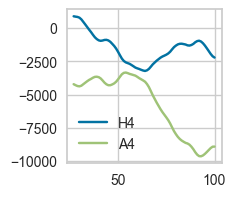

In [12]:
# Duplicando o dataset para Under
df_under = df.copy()

df_under = df_under[(df_under['P(O)'] > 0.508) & (df_under['P(O)'] < 0.548)]
df_under = df_under[(df_under['P(A)'] < 0.535)]
df_under = df_under[((df_under['P(U)'] > 0.507) & (df_under['P(U)'] < 0.527)) | ((df_under['P(U)'] > 0.537) & (df_under['P(U)'] < 0.557))]
df_under = df_under[((df_under['Last_CG_A'] < 10)) | ((df_under['Last_CG_A'] > 14) & (df_under['Last_CG_A'] < 28))]
df_under = df_under[((df_under['Avg_CG_H'] > 4) & (df_under['Avg_CG_H'] < 10)) | ((df_under['Avg_CG_H'] > 12) & (df_under['Avg_CG_H'] < 16))]
df_under = df_under[(df_under['Avg_CG_A'] > 2)]
df_under = df_under[(df_under['Porc_Over_Home'] < 0.9)]

df_under_conferencia = df_under.copy()

df_under['Bet'] = 'Under'
df_under = df_under[['Time', 'League','Home', 'Away', 'Over_Line', 'Odds_Under', 'Bet']]
df_under.sort_values('Time', inplace=True)
df_under.reset_index(drop=True, inplace=True)

print('------------ MÉTODO UNDER ------------\n')
leagues = df_under['League'].unique().tolist()
for lig in leagues:
    tr0 = pd.read_csv(f'data/{lig}/{lig}-2022.csv')
    tr1 = pd.read_csv(f'data/{lig}/{lig}-2023.csv')
    tr = pd.concat([tr0, tr1])
    tr.reset_index(drop=True, inplace=True)
    res, tr = teoria_retornos(tr, target='Back_Over', odds=['Odds_Over', 'Odds_Under'], outputs=['O', 'U'])
    print(f'Teoria dos retornos para a {lig}:', res)
    display(df_under[df_under['League'] == lig])
    tr[['H4', 'A4']].plot(figsize=(2,2))